In [ ]:
!pip install opencv-python

In [ ]:
!pip install plotly

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# Camera calibration

In [ ]:
import cv2
import numpy as np
import os

# Chessboard size (internal corners)
chessboard_size = (8, 6)
square_size = 1  # Realative size (optional)

# 3D points position inside the chessboard
obj_points = np.zeros((chessboard_size[0] * chessboard_size[1], 3), np.float32)
obj_points[:, :2] = np.mgrid[0:chessboard_size[0], 0:chessboard_size[1]].T.reshape(-1, 2)
obj_points *= square_size

# Storing 2D and 3D points
obj_points_list = []  # Real 3D points
img_points_list = []  # 2D Image points

path= "/content/drive/MyDrive/SFM/chess"
images= os.listdir(path)

for fname in images:
    img = cv2.imread(os.path.join(path, fname))
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

    # Detecta las esquinas del tablero
    ret, corners = cv2.findChessboardCorners(gray, chessboard_size, None)

    if ret:
        obj_points_list.append(obj_points)
        img_points_list.append(corners)


# Calibration
ret, K, dist, rvecs, tvecs = cv2.calibrateCamera(obj_points_list, img_points_list, gray.shape[::-1], None, None)

print("Intrinsics Matrix (K):\n", K)
print("Distortion coefficients (dist):\n", dist)

Intrinsics Matrix (K):
 [[2.88498063e+03 0.00000000e+00 1.50810456e+03]
 [0.00000000e+00 2.89392408e+03 2.06858771e+03]
 [0.00000000e+00 0.00000000e+00 1.00000000e+00]]
Distortion coefficients (dist):
 [[ 7.38983902e-02  1.44364069e+00  2.30518419e-03  9.60029464e-04
  -8.80069551e+00]]


# TWO VIEW STRUCTURE FROM MOTION

In [ ]:
import cv2
import os
import matplotlib.pyplot as plt


#Read two images
path= "/content/drive/MyDrive/SFM/tripode"
images= [ os.path.join(path, img) for img in os.listdir(path)]
image_list=[]
for img in images:
    img= cv2.imread(img)
    image_list.append(img)


img1= image_list[0]
img2= image_list[1]


## Reading the images

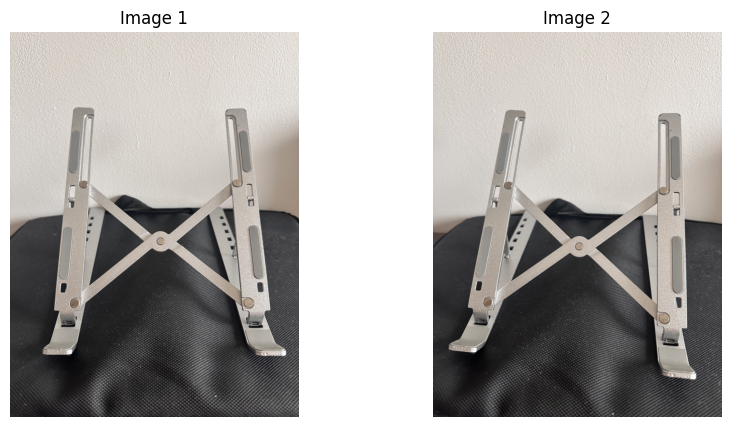

In [ ]:
# Convert from BGR (OpenCV default) to RGB for proper display in Matplotlib
img1_rgb = cv2.cvtColor(img1, cv2.COLOR_BGR2RGB)
img2_rgb = cv2.cvtColor(img2, cv2.COLOR_BGR2RGB)

# Display the images side by side in Jupyter Notebook
plt.figure(figsize=(10,5))

plt.subplot(1, 2, 1)
plt.imshow(img1_rgb)
plt.title('Image 1')
plt.axis('off')  # Hide axes

plt.subplot(1, 2, 2)
plt.imshow(img2_rgb)
plt.title('Image 2')
plt.axis('off')

plt.show()

## Keypoint detection

In [ ]:
# Step 1: Keypoint Detection using SIFT
def detect_keypoints(img):
    sift = cv2.SIFT_create()
    keypoints, descriptors = sift.detectAndCompute(img, None)
    return keypoints, descriptors

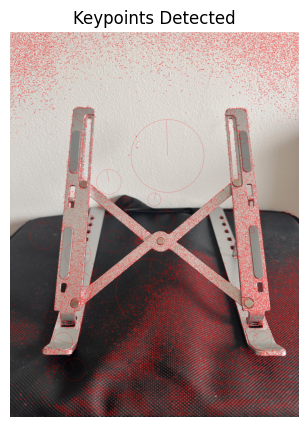

In [ ]:
# Step 1: Detect keypoints
gray_image1= cv2.cvtColor(img1, cv2.COLOR_BGR2GRAY)
gray_image2= cv2.cvtColor(img2, cv2.COLOR_BGR2GRAY)
kp1, des1 = detect_keypoints(gray_image1)
kp2, des2 = detect_keypoints(gray_image2)

img_keypoints= cv2.drawKeypoints(img1, kp1, None, color=(0,0,255) ,flags=cv2.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS)

#Plot
plt.figure(figsize=(10, 5))
plt.imshow(cv2.cvtColor(img_keypoints, cv2.COLOR_BGR2RGB))
plt.title('Keypoints Detected')
plt.axis('off')
plt.show()

In [ ]:
# Step 2: Match Correspondences using FLANN
def match_keypoints(des1, des2):
    index_params = dict(algorithm=1, trees=5)
    search_params = dict(checks=50)
    flann = cv2.FlannBasedMatcher(index_params, search_params)
    matches = flann.knnMatch(des1, des2, k=2)

    # Apply Lowe's ratio test
    good_matches = []
    for m, n in matches:
        if m.distance < 0.75 * n.distance:
            good_matches.append(m)
    return good_matches

In [ ]:
# Step 1: Detect keypoints
kp1, des1 = detect_keypoints(img1)
kp2, des2 = detect_keypoints(img2)

# Step 2: Match keypoints
matches = match_keypoints(des1, des2)

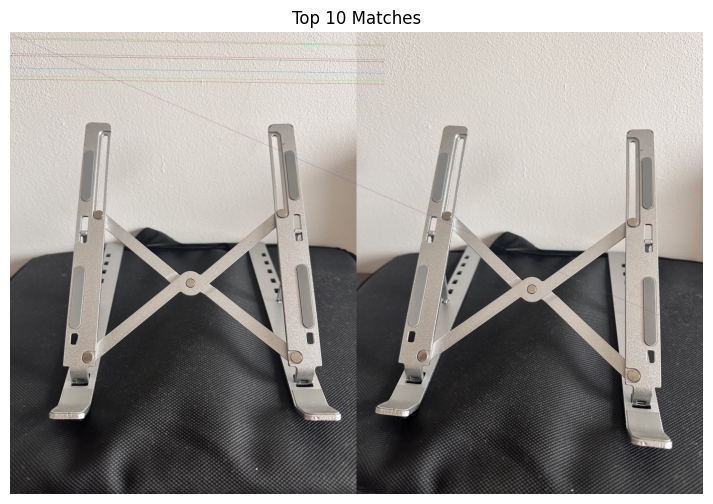

In [ ]:
# Draw the top 10 matches
img_matches = cv2.drawMatches(img1_rgb, kp1, img2_rgb, kp2, matches[:10], None, flags=cv2.DrawMatchesFlags_NOT_DRAW_SINGLE_POINTS)

# Display the matches inline in Jupyter
plt.figure(figsize=(12, 6))  # Adjust the figure size to control the display size
plt.imshow(img_matches)
plt.title('Top 10 Matches')
plt.axis('off')  # Hide axis for cleaner output
plt.show()

## Computing Fundamental Matrix

In [ ]:
import numpy as np
# Step 3: Compute Fundamental Matrix
def compute_fundamental(kp1, kp2, matches):
    pts1 = np.float32([kp1[m.queryIdx].pt for m in matches])
    pts2 = np.float32([kp2[m.trainIdx].pt for m in matches])
    F, mask = cv2.findFundamentalMat(pts1, pts2, cv2.FM_8POINT)
    return F, pts1, pts2

In [ ]:
# Step 3: Compute Fundamental Matrix
F, pts1, pts2 = compute_fundamental(kp1, kp2, matches)

In [ ]:
F

array([[ 4.33045703e-07,  3.05901111e-06, -1.42457346e-02],
       [-3.79074082e-06,  2.89870916e-07,  2.49414226e-02],
       [ 1.37355480e-02, -2.58421577e-02,  1.00000000e+00]])

## Getting the Intrinsics Matrix

In [ ]:
focal_length= 24 #24mm Iphone 14 pro main camera
sensor_width= 9.8 #9.8mm Iphone 14 pro main camera

shape= img1.shape
img_height= shape[0]
img_width= shape[1]

fx = focal_length * (img_width / sensor_width)

# Principal point (center of the image)
cx = img_width / 2
cy = img_height / 2

# Camera intrinsics matrix K
K = np.array([[fx, 0, cx],
              [0, fx, cy],
              [0, 0, 1]])
K

array([[7.40571429e+03, 0.00000000e+00, 1.51200000e+03],
       [0.00000000e+00, 7.40571429e+03, 2.01600000e+03],
       [0.00000000e+00, 0.00000000e+00, 1.00000000e+00]])

In [ ]:
# Step 4: Compute Essential Matrix (E = K' * F * K)
def compute_essential(F, K):
    E = K.T @ F @ K
    return E


In [ ]:
# Step 4: Compute Essential Matrix
E = compute_essential(F, K)

## Estimate camara pose from Essential Matrix

In [ ]:
# Step 5: Estimate Camera Pose from Essential Matrix
def decompose_essential(E, pts1, pts2, K):
    # Recover the rotation and translation from the essential matrix
    _, R, t, mask = cv2.recoverPose(E, pts1, pts2, K)
    return R, t

In [ ]:
# Step 5: Estimate Camera Pose (Rotation and Translation)
R, t = decompose_essential(E, pts1, pts2, K)


In [ ]:
print("Rotation Matrix:\n", R)
print("Translation Vector:\n", t)

Rotation Matrix:
 [[ 0.9943485  -0.07115881  0.07878757]
 [ 0.06920341  0.9972295   0.02728041]
 [-0.08051053 -0.02167387  0.99651809]]
Translation Vector:
 [[-0.86400044]
 [-0.32692563]
 [-0.38291367]]


## Triangulate points

In [ ]:
# Step 6: Triangulate Points to Reconstruct Sparse 3D Structure
def triangulate_points(kp1, kp2, matches, K, R, t):
    pts1 = np.float32([kp1[m.queryIdx].pt for m in matches])
    pts2 = np.float32([kp2[m.trainIdx].pt for m in matches])

    # Normalize points (convert to camera coordinates)
    pts1_norm = cv2.undistortPoints(np.expand_dims(pts1, axis=1), K, None)
    pts2_norm = cv2.undistortPoints(np.expand_dims(pts2, axis=1), K, None)

    # Projection matrices (P1 = [I|0], P2 = [R|t])
    P1 = np.hstack((np.eye(3), np.zeros((3, 1))))
    P2 = np.hstack((R, t))

    # Triangulate points
    points_4D = cv2.triangulatePoints(P1, P2, pts1_norm, pts2_norm)
    points_3D = points_4D[:3] / points_4D[3]

    return points_3D.T  # Transpose for easier handling


In [ ]:
import scipy
# Non-Linear Triangulation Function
def triangulate_nonlinear(kp1, kp2, matches, K, R, t):
    points_4D = []

    # Compute the projection matrices for the two views
    P1 = np.hstack((np.eye(3), np.zeros((3, 1))))  # [I|0] for the first camera
    P1 = K @ P1

    P2 = np.hstack((R, t.reshape(-1, 1)))  # [R|t] for the second camera
    P2 = K @ P2

    # Helper function to compute reprojection residual
    def reprojection_residual(X, pt1, pt2, P1, P2):
        X = np.append(X, 1)  # Convert to homogeneous coordinates

        # Reproject onto the two images
        x1_proj = P1 @ X
        x2_proj = P2 @ X

        # Convert to non-homogeneous coordinates
        x1_proj = x1_proj[:2] / x1_proj[2]
        x2_proj = x2_proj[:2] / x2_proj[2]

        # Residuals (difference between observed and projected points)
        residual = np.hstack((pt1 - x1_proj, pt2 - x2_proj))
        return residual

    # Iterate over each match and triangulate points
    for match in matches:
        idx1 = match.queryIdx
        idx2 = match.trainIdx

        pt1 = np.float32(kp1[idx1].pt)  # Get keypoint from image 1
        pt2 = np.float32(kp2[idx2].pt)  # Get keypoint from image 2

        # Normalize the points using K (intrinsics matrix)
        pt1_norm = np.linalg.inv(K) @ np.append(pt1, 1)
        pt2_norm = np.linalg.inv(K) @ np.append(pt2, 1)

        # Initial linear triangulation to get a starting point
        X_initial = cv2.triangulatePoints(P1, P2, pt1_norm[:2].reshape(-1, 1), pt2_norm[:2].reshape(-1, 1))
        X_initial = X_initial[:3] / X_initial[3]  # Convert to non-homogeneous

        # Use non-linear optimization (Levenberg-Marquardt)
        result = scipy.optimize.least_squares(reprojection_residual, X_initial.flatten(),
                                              args=(pt1, pt2, P1, P2))
        points_4D.append(result.x)

    return np.array(points_4D)

In [ ]:
# Reprojection Error Calculation
def reprojection_error(points_3D, kp1, kp2, matches, K, R, t):
    total_error = 0

    # Compute the projection matrices
    P1 = np.hstack((np.eye(3), np.zeros((3, 1))))  # First camera matrix [I|0]
    P1 = K @ P1

    P2 = np.hstack((R, t.reshape(-1, 1)))  # Second camera matrix [R|t]
    P2 = K @ P2

    # Calculate the reprojection error for each point
    for i, match in enumerate(matches):
        idx1 = match.queryIdx
        idx2 = match.trainIdx

        pt1 = np.float32(kp1[idx1].pt)
        pt2 = np.float32(kp2[idx2].pt)

        point_3D = points_3D[i]

        # Convert 3D point to homogeneous coordinates
        point_3D_hom = np.hstack((point_3D, 1))

        # Project the 3D point back to both image planes
        proj1 = P1 @ point_3D_hom
        proj2 = P2 @ point_3D_hom

        # Convert to non-homogeneous
        proj1 /= proj1[2]
        proj2 /= proj2[2]

        # Calculate the error as the Euclidean distance between projected and actual points
        error1 = np.linalg.norm(pt1 - proj1[:2])
        error2 = np.linalg.norm(pt2 - proj2[:2])

        total_error += error1 + error2

    return total_error / len(matches)


In [ ]:
# Step 6: Triangulate keypoints to reconstruct 3D structure
points_3D = triangulate_points(kp1, kp2, matches, K, R, t)
#  Calculate the Reprojection Error
error = reprojection_error(points_3D, kp1, kp2, matches, K, R, t)
print(f"Reprojection Error: {error}")

Reprojection Error: 76.72368491249907


In [ ]:
# Step 2: Perform Non-linear Triangulation
points_3D_nonlinear = triangulate_nonlinear(kp1, kp2, matches, K, R, t)

# Step 3: Calculate the Reprojection Error
error = reprojection_error(points_3D_nonlinear, kp1, kp2, matches, K, R, t)
print(f"Reprojection Error: {error}")

Reprojection Error: 74.83427627465997


## Plotting the 3D points

In [ ]:
import plotly.graph_objs as go
from plotly.subplots import make_subplots


# Filter outliers by distance threshold
def filter_points(points_3D, distance_threshold=1000):
    distances = np.linalg.norm(points_3D, axis=1)
    filtered_points = points_3D[distances < distance_threshold]
    return filtered_points

# Interactive 3D plot with filtered points
def interactive_plot_3D_points(points_3D, distance_threshold=1000):
    # Filter points based on the threshold
    points_3D_filtered = filter_points(points_3D, distance_threshold)

    # Create plot with filtered points
    fig = go.Figure(data=[go.Scatter3d(
        x=points_3D_filtered[:, 0],
        y=points_3D_filtered[:, 1],
        z=points_3D_filtered[:, 2],
        mode='markers',
        marker=dict(
            size=3,  # Increase marker size
            color=points_3D_filtered[:, 2],  # Color based on depth (Z coordinate)
            colorscale='Viridis',
            opacity=0.8
        )
    )])

    # Set up the layout
    fig.update_layout(
        scene=dict(
            xaxis=dict(title='X'),
            yaxis=dict(title='Y'),
            zaxis=dict(title='Z')
        ),
        margin=dict(r=0, l=0, b=0, t=0),
        height=700
    )
    fig.show()



In [ ]:
# Step 7: Plot the reconstructed 3D points (LINEAR TRIANGULATION)
interactive_plot_3D_points(points_3D_nonlinear, distance_threshold=100)

## Applying RANSAC for Outlier Rejection

In [ ]:
# Compute Fundamental Matrix with RANSAC
def compute_fundamental_RANSAC(kp1, kp2, matches):
    pts1 = np.float32([kp1[m.queryIdx].pt for m in matches])
    pts2 = np.float32([kp2[m.trainIdx].pt for m in matches])

    # Step 2: Use RANSAC to compute the Fundamental Matrix with outlier rejection
    F, inliers = cv2.findFundamentalMat(pts1, pts2, cv2.FM_RANSAC, ransacReprojThreshold=1, confidence=0.99)

    return F, inliers, pts1, pts2

F, inliers, pts1, pts2 = compute_fundamental_RANSAC(kp1, kp2, matches)

In [ ]:
# Step 3: Select inliers based on the RANSAC output
inlier_matches = [m for i, m in enumerate(matches) if inliers[i]]


# Print the number of inliers and the total number of matches for comparison
print(f"Total matches: {len(matches)}")
print(f"Inlier matches after RANSAC: {len(inlier_matches)}")



Total matches: 7661
Inlier matches after RANSAC: 4544


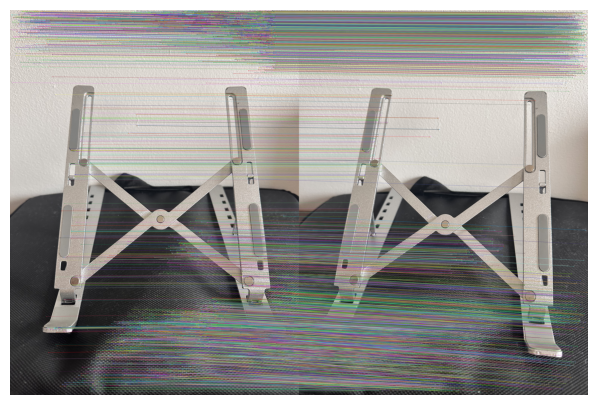

In [ ]:
# Step 4: Draw inlier matches to check results
img_matches = cv2.drawMatches(img1, kp1, img2, kp2, inlier_matches, None, flags=cv2.DrawMatchesFlags_NOT_DRAW_SINGLE_POINTS)

plt.figure(figsize=(10, 5))
plt.imshow(cv2.cvtColor(img_matches, cv2.COLOR_BGR2RGB))
plt.axis('off')
plt.show()

In [ ]:
#The Essential Matrix is the same, we just need to filter the points based on the inliers
pts1_inlier= pts1[inliers.ravel() == 1]
pts2_inlier= pts2[inliers.ravel() == 1]

# Step 5: Estimate Camera Pose (Rotation and Translation)
R, t = decompose_essential(E, pts1_inlier, pts2_inlier, K)
print("Rotation Matrix:\n", R)
print("Translation Vector:\n", t)

Rotation Matrix:
 [[ 0.9943485  -0.07115881  0.07878757]
 [ 0.06920341  0.9972295   0.02728041]
 [-0.08051053 -0.02167387  0.99651809]]
Translation Vector:
 [[-0.86400044]
 [-0.32692563]
 [-0.38291367]]


In [ ]:
# Step 7: Triangulate points using the inlier matches
points_3D_ransac = triangulate_nonlinear(kp1, kp2, inlier_matches, K, R, t)

# Step 8: Calculate reprojection error for RANSAC-enhanced 3D reconstruction
error_ransac = reprojection_error(points_3D_ransac, kp1, kp2, inlier_matches, K, R, t)
print(f"Reprojection Error with RANSAC: {error_ransac}")

Reprojection Error with RANSAC: 48.604148106171216


In [ ]:
# Step 9: Visualize 3D points (optional)
interactive_plot_3D_points(points_3D_ransac, distance_threshold=100)

In [ ]:
len(points_3D_ransac)

59

# Multi view Reconstruction

In [ ]:
# Initialize 3D points container and list for camera poses
all_points_3D = []
camera_poses = []

# Main function for multi-view reconstruction
def multi_view_reconstruction(image_list, K):
    global all_points_3D, camera_poses

    # Process the first two views (initialize with identity and compute pose for the second)
    img1, img2 = image_list[0], image_list[1]
    # Step 1: Detect keypoints
    kp1, des1 = detect_keypoints(img1)
    kp2, des2 = detect_keypoints(img2)

    # Step 2: Match keypoints
    matches = match_keypoints(des1, des2)

    #Fundamental matrix with RANSAC
    F, inliers, pts1, pts2 = compute_fundamental_RANSAC(kp1, kp2, matches)

    # Step 3: Select inliers based on the RANSAC output
    inlier_matches = [m for i, m in enumerate(matches) if inliers[i]]

    # Step 4: Compute Essential Matrix
    E = compute_essential(F, K)

    #The Essential Matrix is the same, we just need to filter the points based on the inliers
    pts1_inlier= pts1[inliers.ravel() == 1]
    pts2_inlier= pts2[inliers.ravel() == 1]

    # Step 5: Estimate Camera Pose (Rotation and Translation)
    R, t = decompose_essential(E, pts1_inlier, pts2_inlier, K)

    # Step 7: Triangulate points using the inlier match and add poses
    points_3D = triangulate_nonlinear(kp1, kp2, inlier_matches, K, R, t)

    all_points_3D.extend(points_3D)
    camera_poses.append((np.eye(3), np.zeros((3, 1))))
    camera_poses.append((R, t))
    print(f"Current 3D points: {len(points_3D)}")
    print(f"All 3D points: {len(all_points_3D)}")

    # Process subsequent views
    for i in range(2, len(image_list)):
        img_curr = image_list[i]
        kp_curr, des_curr = detect_keypoints(img_curr)

        # Match with previous view
        matches = match_keypoints(des2, des_curr)

        #Fundamental matrix with RANSAC
        F, inliers, pts_prev, pts_curr = compute_fundamental_RANSAC(kp2, kp_curr, matches)

        inlier_matches = [m for i, m in enumerate(matches) if inliers[i]]

        E = compute_essential(F, K)

        #The Essential Matrix is the same, we just need to filter the points based on the inliers
        pts1_inlier= pts_prev[inliers.ravel() == 1]
        pts2_inlier= pts_curr[inliers.ravel() == 1]


        R_curr, t_curr = decompose_essential(E, pts1_inlier, pts2_inlier, K)

        # Triangulate and add new points
        points_3D_curr = triangulate_nonlinear(kp2, kp_curr, inlier_matches, K, R_curr, t_curr)
        all_points_3D.extend(points_3D_curr)

        print(f"Current 3D points: {len(points_3D_curr)}")
        print(f"All 3D points: {len(all_points_3D)}")

        # Update camera poses and prepare for next iteration
        camera_poses.append((R_curr, t_curr))
        kp2, des2 = kp_curr, des_curr  # Update to current view for next loop

    return np.array(all_points_3D), camera_poses


In [ ]:
# Perform multi-view reconstruction
points_3D, camera_poses = multi_view_reconstruction(image_list, K)

Current 3D points: 4890
All 3D points: 4890
Current 3D points: 2462
All 3D points: 7352
Current 3D points: 3723
All 3D points: 11075
Current 3D points: 1824
All 3D points: 12899
Current 3D points: 1452
All 3D points: 14351
Current 3D points: 158
All 3D points: 14509
Current 3D points: 43
All 3D points: 14552
Current 3D points: 74
All 3D points: 14626
Current 3D points: 10
All 3D points: 14636
Current 3D points: 11
All 3D points: 14647
Current 3D points: 15
All 3D points: 14662
Current 3D points: 474
All 3D points: 15136
Current 3D points: 3195
All 3D points: 18331
Current 3D points: 2213
All 3D points: 20544
Current 3D points: 2910
All 3D points: 23454
Current 3D points: 3157
All 3D points: 26611
Current 3D points: 1936
All 3D points: 28547
Current 3D points: 71
All 3D points: 28618
Current 3D points: 2795
All 3D points: 31413


In [ ]:
# Step 9: Visualize 3D points (optional)
interactive_plot_3D_points(points_3D, distance_threshold=30)

In [ ]:
points_3D[0:10]

array([[-0.8488849 , -0.54903596,  4.23964671],
       [-0.84227913, -1.11332122,  4.39855083],
       [-0.84164657, -1.11268585,  4.39667493],
       [-0.7353032 ,  0.16507587,  3.85383451],
       [-0.82957132, -1.10081041,  4.41401999],
       [-0.82059997, -1.12297889,  4.43933577],
       [-0.82017179, -1.13157742,  4.43968549],
       [-0.81684101, -1.11616934,  4.44744277],
       [-0.58299633,  0.10741143,  4.0009995 ],
       [-0.44665254,  0.24812348,  3.63651696]])

In [ ]:
points_3D[300:320]

array([[-0.09813001,  0.58779267,  4.23564096],
       [-0.09696837, -0.59226981,  4.03140413],
       [-0.09475451,  0.60441896,  4.22797993],
       [-0.09423173, -0.60164809,  4.02941737],
       [-0.09333551,  0.60545584,  4.22537506],
       [-0.09085608,  0.5878105 ,  4.23946636],
       [-0.08851701,  0.85899246,  4.28241441],
       [-0.08379462,  0.61564152,  4.22088263],
       [-0.09348169,  0.05265876,  4.64753544],
       [-0.08892194,  0.05304222,  4.64978445],
       [-0.08892194,  0.05304222,  4.64978445],
       [-0.08874894,  0.03315699,  4.64103141],
       [-0.08855859,  0.02324622,  4.63953025],
       [-0.0880514 ,  0.02020789,  4.6395214 ],
       [-0.08772251,  0.01686406,  4.64048214],
       [-0.07491241,  0.81864884,  4.26849554],
       [-0.06420502,  0.45238291,  4.19446216],
       [-0.06083963,  0.62784951,  4.21635571],
       [-0.05829114,  0.67485257,  4.22576827],
       [-0.02613105,  0.85698371,  4.38328103]])

https://github.com/ShengyuH/PySFM/blob/master/south_building.ipynb